## Backbone Freezing

In [41]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

backbone = resnet50(weights=ResNet50_Weights)

# Your original training code remains the same
train_backbone = True  
for name, parameter in backbone.named_parameters():
    if not train_backbone or 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
        parameter.requires_grad_(False)

c:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This code will freeze any layer that does not contain layer2, layer3, or layer4 in its name.

**Why?** 

The backbone was pre-trained on `ImageNet`, and early layers like `conv1` + `layer1` are responsible for capturing low-level features (e.g., edges, textures). These features are generally useful for a wide range of tasks, so we want to retain them during fine-tuning.

Later layers (e.g., `layer2`, `layer3`, `layer4`) learned features specific to ImageNet classes.


In [23]:
# Check which parameters are trainable
trainable_params = []
frozen_params = []

for name, param in backbone.named_parameters():
    if param.requires_grad:
        trainable_params.append(name)
    else:
        frozen_params.append(name)

print("Trainable parameters:")
for name in trainable_params[:5]:  # Show first 5
    print(f"  {name}")

for name in frozen_params[:5]:  # Show first 5
    print(f"  {name}")

print(f"\nTotal trainable: {len(trainable_params)}")
print(f"Total frozen: {len(frozen_params)}")

Trainable parameters:
  layer2.0.conv1.weight
  layer2.0.bn1.weight
  layer2.0.bn1.bias
  layer2.0.conv2.weight
  layer2.0.bn2.weight
  conv1.weight
  bn1.weight
  bn1.bias
  layer1.0.conv1.weight
  layer1.0.bn1.weight

Total trainable: 126
Total frozen: 35


BatchNorm layers

What is **Batch Normalization**? 

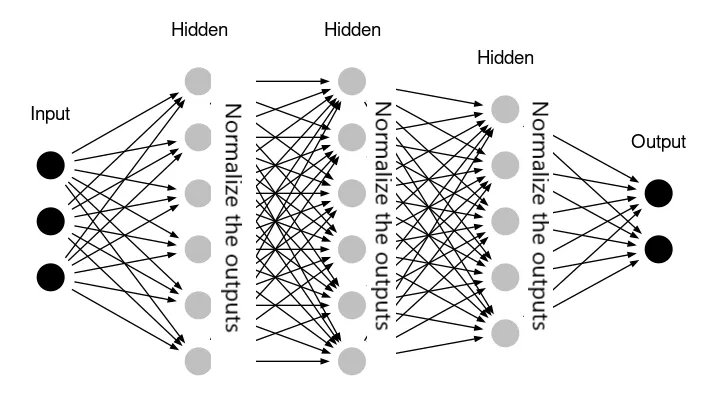

As you can see in the previous image, 

- **Batch normalization** will be applied after each layer ***before*** passing the **outputs** to the **activation** function
    - In this order `Conv → BatchNorm → Activation`

- **Batch normalization** idea is to convert the layer output mean to 0 and variance to 1

- It contains 4 main components:
    1. **weight**: The scale parameter for the normalized output. (**Trainable** in training mode) (**Constant** in FrozenBatchNorm)
    2. **bias**: The shift parameter for the normalized output. (**Trainable** in training mode) (**Constant** in FrozenBatchNorm)
    3. **running_mean**: The running mean of the input values (used during **inference** only) (updated during **training**)
    4. **running_var**: The running variance of the input values (used during **inference** only) (updated during **training**)

Why? 


Based on [this discussion](https://github.com/facebookresearch/maskrcnn-benchmark/issues/267)

**"The reason why we use FrozenBatchNorm2d instead of BatchNorm2d is that the sizes of the batches are very small, which makes the batch statistics very poor and degrades performance."**

This is from 12 Dec 2018, I think there is a solution for this case.


Now, What's the difference between **Batch Normalization** and **Layer Normalization**?

The simplest way to understand the difference between them is based on this image:

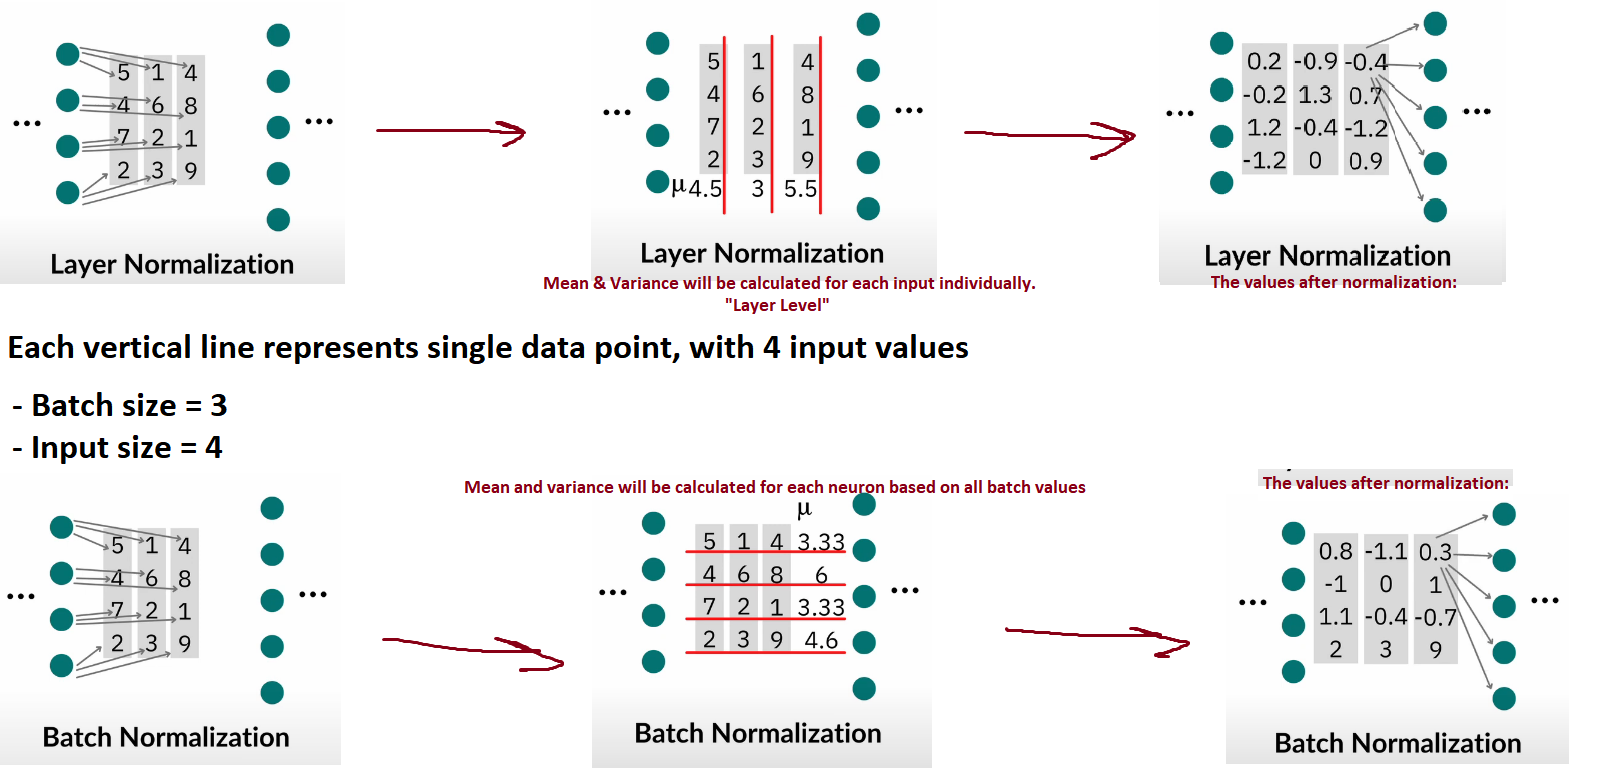

- In **Computer Vision**: BN still dominates, but LN or GroupNorm are used when batch size is small. (Need to check this information)

- In **NLP / Transformers**: LN is preferred; BN rarely used. especially in **Transformers** architectures.

**BatchNorm** really helps training go faster and handle bigger learning rates, but mainly when you’re training **CNNs** with reasonably **large** batch sizes.

**but** comparable to or worse than LN once you factor in small batches or distributed training.